In [1]:
import pandas as pd

In [2]:
import itertools
import numpy as np

Ignore, was for another dataset I was experimenting with

In [3]:
# sleep_data_p1 = pd.read_json("GarminExport_4-27-23/DI_CONNECT/DI-Connect-Wellness/2022-10-09_2023-01-17_110095977_sleepData.json")

In [4]:
# sleep_data_p1.head()

In [5]:
# sleep_data_p2 = pd.read_json("GarminExport_4-27-23/DI_CONNECT/DI-Connect-Wellness/2023-01-17_2023-04-27_110095977_sleepData.json")

In [6]:
# sleep_data = pd.concat([sleep_data_p1, sleep_data_p2])
# sleep_data

In [7]:
# activity_summary = pd.read_json("GarminExport_4-27-23/DI_CONNECT/DI-Connect-Fitness/trey11sport@gmail.com_0_summarizedActivities.json")
# activity_summary.head()

In [8]:
# Load Main dataset
udisc = pd.read_csv("code/data/UDiscScorecards.csv")
udisc.head()

,PlayerName,CourseName,Date,Total,+/-,Hole1,Hole2,Hole3,Hole4,Hole5,...,Hole20,Hole21,Hole22,Hole23,Hole24,Hole25,Hole26,Hole27,Hole28,Hole29
0,Par,Hillcrest Park,2023-05-30 1129,54,NaN,3,3,3,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Trey Scheid,Hillcrest Park,2023-05-30 1129,60,6.0,3,3,4,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Shane Johnson,Hillcrest Park,2023-05-30 1129,59,5.0,2,3,6,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Ryan,Hillcrest Park,2023-05-30 1129,81,27.0,5,4,6,6,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Par,Morley Field,2023-05-24 1151,57,NaN,3,3,3,3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
udisc.shape[0]

901

In [10]:
#remove cols / rows unneeded
# udisc = udisc.drop(columns=["LayoutName"])
udisc = udisc[udisc["CourseName"] != "Dunno Where/When"]

## EDA

In [11]:
# udisc[udisc["PlayerName"] == "Trey Scheid"].groupby("CourseName").count().sort_values(by="Date", ascending=False)

In [12]:
# udisc[(udisc["PlayerName"] != "Trey Scheid") & (udisc["PlayerName"] != "Par")]

In [13]:
udisc.groupby("CourseName")["+/-"].mean().sort_values()

CourseName
Hanns Park                       0.750000
Creekside Park                   2.000000
Walden Park                      3.039301
Mast Park                        3.400000
Kit Carson Park                  3.500000
La Mirada Regional Park Back     4.600000
Hillcrest Park                   4.712000
Rosa Park                        5.000000
New Hogan Dam East               5.166667
New Hogan Dam West               6.000000
Hume Lake Christian Camp         6.142857
Benicia Community Park           6.840000
Kelley Park Disc Golf            7.000000
Lake Chabot Golf Course          8.366667
Chavez Ridge at Elysian          8.500000
Taylor Mountain                  8.666667
Lagoon Valley                    8.666667
Golden Gate Park                 8.719512
Monarch Bay                      9.500000
Moraga Commons Park              9.870968
Aquatic Park                    10.222222
Morley Field                    11.448276
DeLaveaga Disc Golf Course      18.857143
Oyster Bay Disc Golf Co

In [14]:
# udisc.groupby(["PlayerName"])["Total"].count().sort_values(ascending=False).index#.unique()

In [15]:
# merge same entities
unify_names = {"James Park":"James ", "Shane":"Shane Johnson", "Todd":"Todd Scheid", "Jeffrey Farmer":"Jeffrey"}
udisc = udisc.replace(unify_names)

### Export Cleaned udisc scorecards

In [16]:
udisc.to_csv("code/data/UDiscScorecards.csv", index=False)

# Node Link Creation

In [17]:
# duplicate rows so that rounds of 18 have two rows and of 27 have three 

oneround = udisc[udisc["PlayerName"] != "Par"].copy()
tworound = oneround[pd.isnull(udisc[udisc["PlayerName"] != "Par"]["Hole10"])].copy()
threeround = oneround[pd.isnull(udisc[udisc["PlayerName"] != "Par"]["Hole20"])].copy()
udisc_rounds = pd.concat([oneround, tworound, threeround])
print(oneround.shape[0])
udisc_rounds.shape[0]

682


1694

In [18]:
# now each row is metadata for a round of exactly 9 for one person

In [19]:
round_people = udisc_rounds.groupby(["Date", "CourseName"])["PlayerName"].aggregate(list)
round_people

Date             CourseName            
2016-11-11 0000  Moraga Commons Park                 [Trey Scheid, Trey Scheid, Trey Scheid]
2016-11-11 1741  Walden Park               [Shane Johnson, Skyler, Reid, Shane Johnson, S...
2016-11-13 1744  Benicia Community Park    [Trey Scheid, Todd Scheid, Shane Johnson, Trey...
2017-03-12 1408  Walden Park               [Trey Scheid, Todd Scheid, Trey Scheid, Todd S...
2017-03-26 1413  Walden Park               [Trey Scheid, Todd Scheid, Trey Scheid, Todd S...
                                                                 ...                        
2023-05-19 1345  Kit Carson Park           [Bradley, Bing bing, Trey Scheid, Bradley, Bin...
2023-05-22 1523  Kit Carson Park           [Trey Scheid, Shane Johnson, Trey Scheid, Shan...
2023-05-24 0922  Morley Field              [Trey Scheid, Shane Johnson, Eduardo, Trey Sch...
2023-05-24 1151  Morley Field              [Trey Scheid, Shane Johnson, Eduardo, Trey Sch...
2023-05-30 1129  Hillcrest Par

In [20]:
# create source target pairs from each scorecard (row)
link_list = []
for i in (round_people.apply(lambda l: list(itertools.combinations(l, 2))).to_list()):
    link_list += i

In [21]:
# reformat as df
finishing_links = pd.DataFrame(link_list, columns=["source", "target"])
finishing_links["value"] = 0
finishing_links = finishing_links.groupby(["source", "target"]).count().reset_index()

In [22]:
#json format links
links = finishing_links.to_json(orient="records")
links

'[{"source":"Bing bing","target":"Bing bing","value":1},{"source":"Bing bing","target":"Bradley","value":1},{"source":"Bing bing","target":"Trey Scheid","value":3},{"source":"Bradley","target":"Bing bing","value":3},{"source":"Bradley","target":"Bradley","value":6},{"source":"Bradley","target":"Gummo","value":9},{"source":"Bradley","target":"Keane Kirchner ","value":6},{"source":"Bradley","target":"Trey Scheid","value":8},{"source":"Bradley","target":"Yurt","value":12},{"source":"Chloe","target":"Chloe","value":9},{"source":"Chloe","target":"Eshaan","value":6},{"source":"Chloe","target":"James ","value":6},{"source":"Chloe","target":"Jeffrey","value":1},{"source":"Chloe","target":"Joey","value":6},{"source":"Chloe","target":"Rania","value":3},{"source":"Chloe","target":"Shane Johnson","value":5},{"source":"Chloe","target":"Trey Scheid","value":9},{"source":"Choppa","target":"Choppa","value":1},{"source":"Choppa","target":"Namo","value":1},{"source":"Choppa","target":"Trey Scheid","valu

In [23]:
# format nodes list for json

people = pd.Series(udisc["PlayerName"].unique()[1:].copy())
people = udisc.groupby("PlayerName")["Total"].count().reset_index()
nodes = people.to_json(orient="table").split(",\"data\":")[1].strip("}")
nodes

'[{"index":0,"PlayerName":"Bing bing","Total":1},{"index":1,"PlayerName":"Bradley","Total":4},{"index":2,"PlayerName":"Chloe","Total":5},{"index":3,"PlayerName":"Choppa","Total":1},{"index":4,"PlayerName":"Danny","Total":10},{"index":5,"PlayerName":"Dave","Total":1},{"index":6,"PlayerName":"Eduardo","Total":2},{"index":7,"PlayerName":"Elum","Total":1},{"index":8,"PlayerName":"Eshaan","Total":1},{"index":9,"PlayerName":"George","Total":1},{"index":10,"PlayerName":"Gummo","Total":2},{"index":11,"PlayerName":"Ian McDavid","Total":1},{"index":12,"PlayerName":"Isaiah","Total":3},{"index":13,"PlayerName":"Jake Gutkowski","Total":1},{"index":14,"PlayerName":"James ","Total":98},{"index":15,"PlayerName":"James  + Rob Park","Total":1},{"index":16,"PlayerName":"Jeffrey","Total":74},{"index":17,"PlayerName":"Joe","Total":1},{"index":18,"PlayerName":"Joey","Total":1},{"index":19,"PlayerName":"Keane Kirchner ","Total":1},{"index":20,"PlayerName":"Keith Farmer","Total":4},{"index":21,"PlayerName":"K

In [24]:
# combine nodes and links ready for d3.js
json_string = "{\"nodes\":" + nodes + ",\"links\":" + links + "}"

In [25]:
# write to json
json_file = open("code/data/nodelink.json", "wt")
nchars = json_file.write(json_string)
json_file.close()

In [26]:
#check success
print(nchars)
len(json_string) == nchars

20077


True

# Time Preprocessing

In [27]:
df = udisc[udisc["PlayerName"] != "Par"][["PlayerName", "CourseName", "Date"]].copy().sort_values(['Date', 'PlayerName']).reset_index(drop=True)
visited = dict.fromkeys(list(df["PlayerName"].unique()), None)
out = pd.Series(index=df.index)
for row in range(df.shape[0]):#
#     print(visited[df.loc[row, "PlayerName"]].add(df.loc[row, "CourseName"]))
#     print(row)
#     print(df.loc[row, "PlayerName"])
    tempset = visited[df.loc[row, "PlayerName"]]
    if (tempset is None):
        tempset = set()
#     print(tempset)
    tempset.add(df.loc[row, "CourseName"])
#     print(tempset)
    visited[df.loc[row, "PlayerName"]] = tempset
    out[row] = len(visited[df.loc[row, "PlayerName"]])

for key, val in visited.items():
    print("k", key, "v", visited[key], "\n\n")

k Trey Scheid v {'DeLaveaga Disc Golf Course', 'Morley Field', 'Oyster Bay Disc Golf Course', 'Mast Park', 'Benicia Community Park', 'Hume Lake Christian Camp', 'Lake Chabot Golf Course', 'Chavez Ridge at Elysian', 'Hillcrest Park', 'Hanns Park', 'Creekside Park', 'Kelley Park Disc Golf', 'Kit Carson Park', 'Walden Park', 'Monarch Bay', 'New Hogan Dam East', 'Moraga Commons Park', 'Taylor Mountain', 'Lagoon Valley', 'New Hogan Dam West', 'Aquatic Park', 'Rosa Park', 'La Mirada Regional Park Back', 'Golden Gate Park'} 


k Reid v {'Walden Park'} 


k Shane Johnson v {'DeLaveaga Disc Golf Course', 'Benicia Community Park', 'New Hogan Dam West', 'Lake Chabot Golf Course', 'Morley Field', 'Aquatic Park', 'Moraga Commons Park', 'Kit Carson Park', 'Walden Park', 'Golden Gate Park', 'New Hogan Dam East', 'Hillcrest Park', 'Hanns Park', 'Lagoon Valley'} 


k Skyler v {'Walden Park', 'Moraga Commons Park'} 


k Todd Scheid v {'DeLaveaga Disc Golf Course', 'Benicia Community Park', 'Morley Field

/var/folders/31/df158hy936q0z2m_dr_493pm0000gn/T/ipykernel_10809/1209228275.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  out = pd.Series(index=df.index)


In [28]:
out

0       1.0
1       1.0
2       1.0
3       1.0
4       2.0
       ... 
677    14.0
678    24.0
679     5.0
680    14.0
681    24.0
Length: 682, dtype: float64

In [29]:
df["CoursesPlayed"] = out

In [30]:
df = df.drop_duplicates(ignore_index=True)

In [31]:
# Create a list of all unique dates and players
all_dates = df['Date'].unique()
all_players = df['PlayerName'].unique()

# Create a multi-index DataFrame with all combinations of dates and players
index = pd.MultiIndex.from_product([all_dates, all_players], names=['Date', 'PlayerName'])
df = df.set_index(['Date', 'PlayerName']).reindex(index)

# Reset the index to convert the multi-index DataFrame to a regular DataFrame
df = df.reset_index()

# Sort the DataFrame by Date and PlayerName
df = df.sort_values(['Date', 'PlayerName'])

# Forward fill missing values within each player group
df['CoursesPlayed'] = df.groupby('PlayerName')['CoursesPlayed'].fillna(method='ffill')

# Fill remaining missing values with 0
df['CoursesPlayed'] = df['CoursesPlayed'].fillna(0)

# Print the resulting dataframe
df

,Date,PlayerName,CourseName,CoursesPlayed
45,2016-11-11 0000,Bing bing,NaN,0.0
39,2016-11-11 0000,Bradley,NaN,0.0
31,2016-11-11 0000,Chloe,NaN,0.0
43,2016-11-11 0000,Choppa,NaN,0.0
18,2016-11-11 0000,Danny,NaN,0.0
...,...,...,...,...
10246,2023-05-30 1129,Trey Scheid,Hillcrest Park,24.0
10261,2023-05-30 1129,Trey Scheid + Todd Scheid,NaN,1.0
10287,2023-05-30 1129,Yurt,NaN,3.0
10284,2023-05-30 1129,Zac,NaN,2.0


Fill in empty rows

In [32]:
df.to_csv("code/data/timepreprocessed.csv", index=False)

## EDA
no correlations found

In [33]:
num_players = udisc.groupby(["CourseName","Date"])["Total"].count() - 1 #-1 for par row
num_players.name = "num_players"
num_players

CourseName              Date           
Aquatic Park            2019-01-01 1600    5
                        2022-08-26 1427    4
Benicia Community Park  2016-11-13 1744    3
                        2017-06-28 1417    4
                        2017-08-04 0000    1
                                          ..
Walden Park             2022-09-07 1219    1
                        2022-09-07 1220    2
                        2022-09-12 1616    3
                        2022-12-13 1432    3
                        2022-12-13 1433    2
Name: num_players, Length: 219, dtype: int64

In [34]:
num_holes = (udisc.groupby(["CourseName", "Date"]).sum() != 0).sum(axis=1) - 2
num_holes.name = "num_holes"
num_holes

CourseName              Date           
Aquatic Park            2019-01-01 1600    18
                        2022-08-26 1427    18
Benicia Community Park  2016-11-13 1744     9
                        2017-06-28 1417     9
                        2017-08-04 0000     9
                                           ..
Walden Park             2022-09-07 1219     9
                        2022-09-07 1220     9
                        2022-09-12 1616    18
                        2022-12-13 1432    18
                        2022-12-13 1433     9
Name: num_holes, Length: 219, dtype: int64

In [35]:
trey_score = udisc[udisc["PlayerName"] == "Trey Scheid"].groupby(["CourseName","Date"])["+/-"].max()
trey_score.name = "trey_score"
trey_score

CourseName              Date           
Aquatic Park            2019-01-01 1600    6.0
                        2022-08-26 1427    2.0
Benicia Community Park  2016-11-13 1744    2.0
                        2017-06-28 1417    8.0
                        2017-08-04 0000    6.0
                                          ... 
Walden Park             2022-09-07 1219   -2.0
                        2022-09-07 1220   -1.0
                        2022-09-12 1616   -5.0
                        2022-12-13 1432   -9.0
                        2022-12-13 1433   -4.0
Name: trey_score, Length: 215, dtype: float64

<AxesSubplot: xlabel='CourseName,Date'>

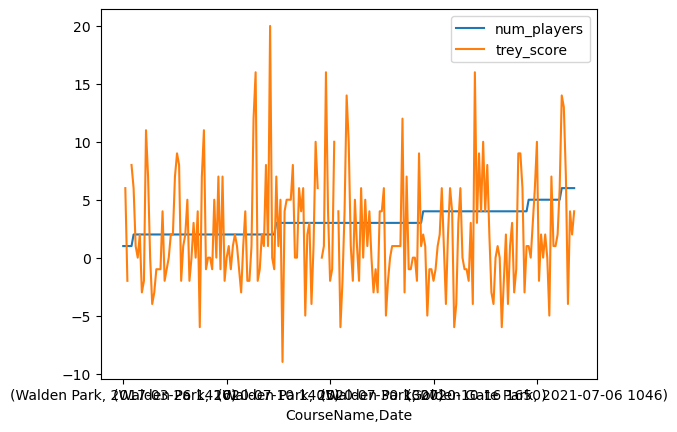

In [36]:
score_by_num = pd.DataFrame([num_players, trey_score]).T.sort_values(by="num_players")
score_by_num.plot()

<AxesSubplot: xlabel='num_players'>

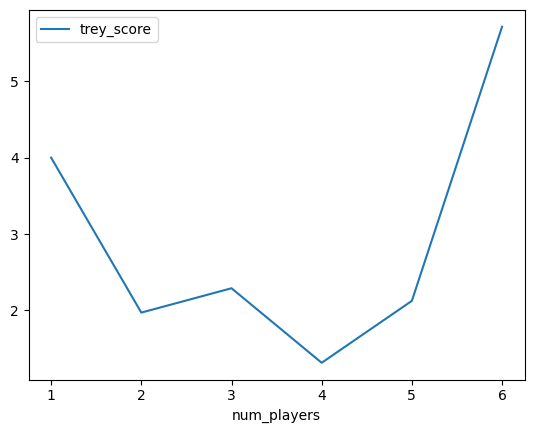

In [37]:
score_by_num.groupby("num_players").mean().plot()

<AxesSubplot: xlabel='num_players'>

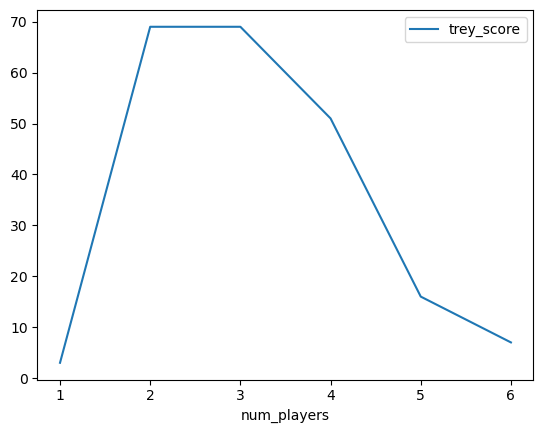

In [38]:
score_by_num.groupby("num_players").count().plot()

In [39]:
# problem could be that i tend to play harder courses with more people or the other way

/var/folders/31/df158hy936q0z2m_dr_493pm0000gn/T/ipykernel_10809/1627704829.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  score_by_length.reset_index().groupby("CourseName")["num_holes", "trey_score"].mean().sort_values(by=["num_holes","trey_score"]).plot()


<AxesSubplot: xlabel='CourseName'>

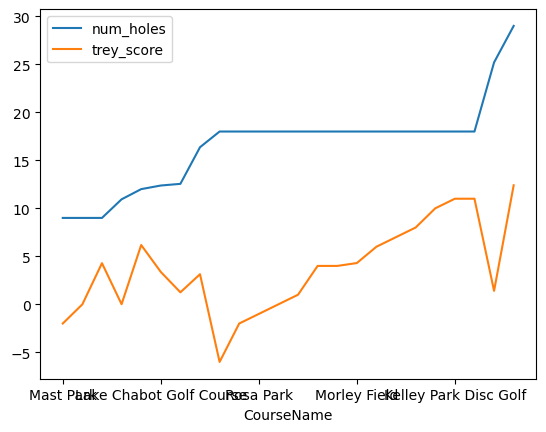

In [40]:
score_by_length = pd.DataFrame([num_holes, trey_score]).T
score_by_length.reset_index().groupby("CourseName")["num_holes", "trey_score"].mean().sort_values(by=["num_holes","trey_score"]).plot()